# The Leaky Integrate-and-Fire (LIF) neuron model

## Objectives

In this notebook, we will build up a leaky integrate-and-fire (LIF) neuron model and study its dynamics in response to various types of inputs. In particular, we are going to write a few lines of codes to  

1) simulate the LIF neuron model

2) drive the LIF neuron with external inputs, including DC current, Gaussian white noise, and Poisson spike trains, etc.

3) demonstrate the statistics of the LIF neuron's output

### Key References
- Shadlen MN, Newsome WT. The variable discharge of cortical neurons: implications for connectivity, computation, and information coding. Journal of neuroscience. 1998 May 15;18(10):3870-96.

- Kuhn A, Aertsen A, Rotter S. Neuronal integration of synaptic input in the fluctuation-driven regime. Journal of Neuroscience. 2004 Mar 10;24(10):2345-56.


Please execute the cell below to initialize the notebook environment.

In [ ]:
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import time                        # import time
import ipywidgets as widgets       # interactive display
from scipy.stats import pearsonr   # import pearson correlation

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

## Leaky integrate-and-fire (LIF) neuron model

One of the simplest mathematical model of a neuron is the Leaky integrate-and-fire (LIF) model. The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron [see a translation of Lapicque's paper [link text](https://pubmed.ncbi.nlm.nih.gov/17968583/)].

The subthreshold membrane potential dynamics of a LIF neuron is described by

\begin{eqnarray}
C_m\frac{dV}{dt} = -g_L(V-V_L) + I,
\end{eqnarray}

where $C_m$ is the membrane capacitance, $V$ is the membrane potential, $g_L$ is the leak conductance, $V_L$ is the resting potential, and $I$ is the external input current.

Dividing both sides of the above equation by $g_L$ gives

\begin{align}
\tau_m\frac{dV}{dt} = -(V-V_L) + \frac{I}{g_L}\,,\quad (1)
\end{align}

where the time constant $\tau_m$ is defined as $\tau_m=C/g_L$. Below we will use Eqn.(1) to simulate the LIF neuron dynamics.

If $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, $V$ is reset to a reset potential $V_{\rm reset}<V_{\rm th}$ and voltage is clamped to $V_{reset}$ for $t_{ref}$ms mimicking the refractoriness of the neuron during an action potential, _i.e._,

\begin{eqnarray}
\mathrm{if}\quad V(t)\geq V_{\rm th}&:& V(t^+)=V_{\rm reset}
\end{eqnarray}

Thus, the LIF model captures the facts that a neuron
- performes spatial and temporal integration of synaptic inputs
- generates a spike when the voltage reaches a certain threshold
- goes refractory during the action potential
- membrane is leaky

The LIF model assumes that spatial and temporal integration of inputs is linear. Also, membrane potential dynamics close to the spike threshold is much slower in LIF neurons than in real neurons.


## Numerical discretization with forward Euler scheme

To numerically solve the membrane potential dynamics of the LIF neuron, we need to discretize the continuous dynamics of Eqn. (1) by using a time-grid of stepsize $\Delta t$. Note that, to ensure an accurate approximation to the solution of Eqn. (1), the time step $\Delta t$ needs to be small compared to all other time constants in the system (here is $\tau_m$). The smaller value $\Delta t$ takes, the better the approximation is. However, the total simulation time will become longer.

On the time-grid of of stepsize $\Delta t$, the dynamics of Eqn. (1) is discretized to be

\begin{eqnarray}
\tau_m \frac{\Delta V_n}{\Delta t} &=& -(V_n-V_L) +\frac{I_n}{g_L},
\end{eqnarray}

where $V_n = V(n\Delta t)$, and $I_n=I(n\Delta t)$.

Then the updating process of $V_{n+1}$ at time $t_{n+1}=(n+1)\Delta t$ based on $V_{n}$ can be formed as

\begin{eqnarray}
V_{n+1} &=& V_n+ \Delta V_n \\
\Delta V_n &=&  \left(-(V_n-V_L) +\frac{I}{g_L}\right)\frac{\Delta t}{\tau_m} \qquad (2)
\end{eqnarray}

## Python code to simulate the LIF neuron

We now **write** a Python code to calculate the Eqn.(2) and simulate the LIF neuron dynamics.

The cell below initializes a dictionary that stores parameters of the LIF neuron model and the simulation scheme.

In [ ]:
def default_pars( **kwargs):
    pars = {}

    ### typical neuron parameters###
    pars['V_th']    = -55. # spike threshold [mV]
    pars['V_reset'] = -75. #reset potential [mV]
    pars['tau_m']   = 10. # membrane time constant [ms]
    pars['g_L']     = 10. #leak conductance [nS]
    pars['V_init']  = -65. # initial potential [mV]
    pars['V_L']     = -75. #leak reversal potential [mV]
    pars['tref']    = 2. # refractory time (ms)

    ### simulation parameters ###
    pars['T'] = 400. # Total duration of simulation [ms]
    pars['dt'] = .1  # Simulation time step [ms]

    ### external parameters if any ###
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]

    return pars

The cell below defines the function to simulate the LIF neuron when receiving external current inputs.

In [ ]:
def run_LIF(pars, I):
    '''
    Simulate the LIF dynamics with external input current

    Expects:
    pars       : parameter dictionary
    I          : input current [pA]. The injected current here can be a value or an array

    Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
    '''

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, V_L = pars['V_init'], pars['V_L']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tref = pars['tref']
    # Initialize voltage and current
    v = np.zeros(Lt)
    v[0] = V_init
    I = I * np.ones(Lt)
    tr = 0.
    # simulate the LIF dynamics
    rec_spikes = []               # record spike times
    for it in range(Lt-1):
      if tr >0:
            v[it] = V_reset
            tr = tr-1
      elif v[it] >= V_th:         #reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref/dt
      #calculate the increment of the membrane potential
      dv = (-(v[it]-V_L) + I[it]/g_L) * (dt/tau_m)

      #update the membrane potential
      v[it+1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes

## Response of an LIF model to different types of input currents
In the following we will inject direct current and white noise to study the response of an LIF neuron.

### Constant current
Execute the following cell to run the LIF neuron when receiving a DC current of 300 pA, and see the voltage response of the LIF neuron.

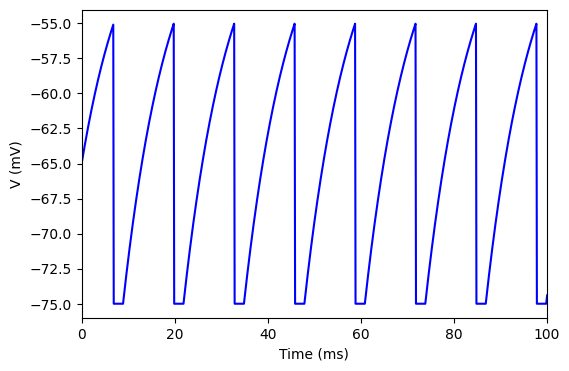

In [ ]:
pars = default_pars()
v, rec_spikes = run_LIF(pars, I = 300.)
plt.plot(pars['range_t'], v, 'b')
plt.xlim(0, 100)
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)');

In [ ]:
def diff_DC(I_dc=300):
  pars = default_pars()
  v, rec_spikes = run_LIF(pars, I = I_dc)
  plt.figure()
  plt.plot(pars['range_t'], v, 'b')
  plt.plot(rec_spikes, np.ones(len(rec_spikes))-55, 'k|')
  plt.xlim(0, 100)
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.show()

_ = widgets.interact(diff_DC, I_dc = (100., 300., 5.))

interactive(children=(FloatSlider(value=300.0, description='I_dc', max=300.0, min=100.0, step=5.0), Output()),…

### Gaussian white noise (GWN) current

Neurons in vivo never receive direct current like inputs. Given the noisy nature of neuronal activity in vivo, neurons receive noisy time varying inputs.

We next investigate the neuronal response when the LIF neuron receives Gaussian white noise $\xi(t)$ with mean

\begin{eqnarray}
E[\xi(t)]=\mu=0,
\end{eqnarray}

and autocovariance
\begin{eqnarray}
E[\xi(t)\xi(t+\tau)]=\sigma_\xi^2 \delta(\tau)
\end{eqnarray}

Hint: In order to have correct statistics of the GWN approximation on a time grid with increment $\Delta t$, the noise amplitide $\sigma_\xi$ needs to be scaled by $1/\sqrt{\Delta t}$.

The cell below defines gaussian white noise currents.

In [ ]:
def my_GWN(pars, sig, myseed=False):
    '''
    Expects:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

    Returns:
    I          : Gaussian white noise input
    '''

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    #generate GWN
    I =  sig * np.random.randn(Lt) / np.sqrt(dt/1000.)

    return I

Execute the cell below to generate the GWN current and plot it out.

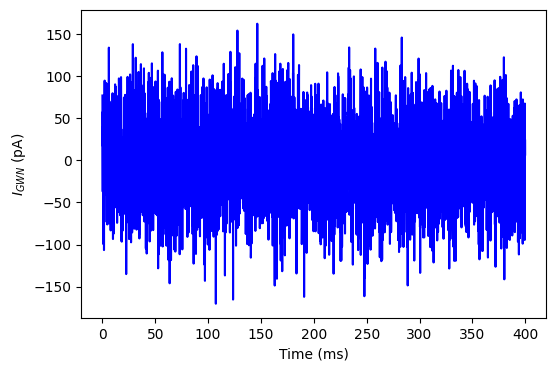

In [ ]:
pars = default_pars()
sig_ou = .5
I_GWN = my_GWN(pars, sig=sig_ou, myseed=1998)
plt.plot(pars['range_t'], I_GWN, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{GWN}$ (pA)');

Execute the cell below to inject the GWN current to the LIF neuron and see its voltage response.

(100.0, 200.0)

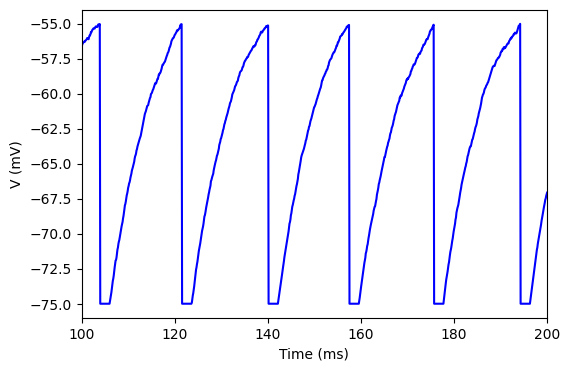

In [ ]:
v, rec_spikes = run_LIF(pars, I =I_GWN+250.)
plt.plot(pars['range_t'], v, 'b')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)');
plt.xlim(100,200)

#### Think
- As we increase input (DC value) or GWN parameters the spike count changes. How much can we increase the spike count and what might be relationship between GWN mean/std or DC value and spike count?

- We have seen above that when we inject DC the neuron spikes in a regular manner (clock like) and this regularity is reduced when GWN is injected. The question is how much irregular can we make the neurons spiking by changing the parameters of the GWN?


#### Firing rate and spike time irregularity
When we plot the output firing rate as a function of GWN mean or DC value, it is called the input-output transfer function of the neuron (so simply F-I curve).

Spike regularity can be quanitfied as **coefficient of variance of the inter-spike-interval**:
\begin{align}
\text{CV}_{\text{ISI}} = \frac{std(\text{isi})}{mean(\text{isi})}
\end{align}

*isi* can be calculate by using np.diff(spike_time)

For completely irregular spiking (i.e. a Poisson Point process) $\textbf{CV}_{\textbf{ISI}} \textbf{= 1}$. And for a clock like process because *std(isi)* is zero $\textbf{CV}_{\textbf{ISI}} \textbf{= 0}$.

###Task: Neuron F-I curve and spike time regularity
To address the above questions we will systematically vary the mean and standard deviation of the injected GWN and plot the F-I curve of the LIF neuron.

In [ ]:
I_mean = np.arange(100.,500.,25)
I_std = np.arange(0.,20.,2)
spk_count = np.zeros((len(I_mean),len(I_std)))
cv_isi = np.empty((len(I_mean),len(I_std)))
cv_isi[:] = np.NaN

for ii in range(len(I_mean)):
  for jj in range(len(I_std)):
    I_GWN = my_GWN(pars, sig=I_std[jj], myseed=1998)
    v, rec_spikes = run_LIF(pars, I =I_GWN+I_mean[ii])
    spk_count[ii,jj] = len(rec_spikes)
    if len(rec_spikes)>3:
      isi = np.diff(rec_spikes)
      cv_isi[ii,jj] = np.std(isi)/np.mean(isi)

#### Lets plot the results.
We are interested in two variables.
- Spike count
- Irregularity of spike pattern



<ipython-input-11-9a830732d348>:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
<ipython-input-11-9a830732d348>:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(0,1)


<Figure size 600x400 with 0 Axes>

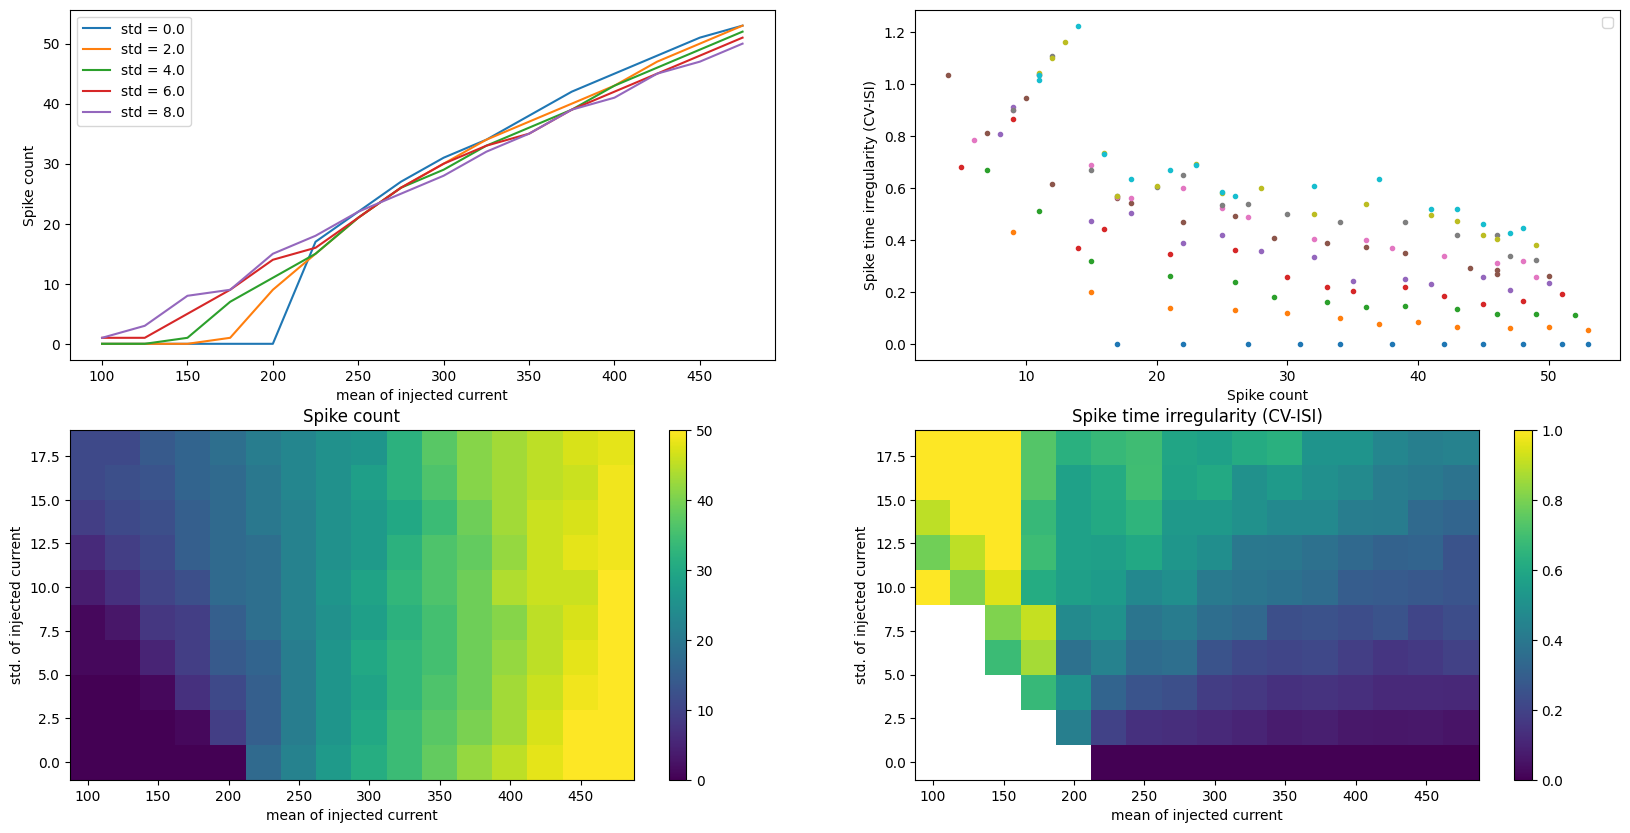

In [ ]:
plt.figure()
plt.figure(figsize=(20, 10))

# Plot the F-I curve i.e. Output firing rate as a function of input mean. Different lines correspond to different std.
# Note how std changes the F-I curve
plt.subplot(2,2,1)
for ii in range(5):
  plt.plot(I_mean,spk_count[:,ii],label='std = '+str(I_std[ii]))
plt.ylabel('Spike count')
plt.xlabel('mean of injected current');
plt.legend()

# Plot firing rate vs coeffcient of variance of inter-spike interval
# Do you see any pattern here?
plt.subplot(2,2,2)
plt.plot(spk_count,cv_isi,'.')
plt.xlabel('Spike count')
plt.ylabel('Spike time irregularity (CV-ISI)');
plt.legend()

# Plot Firing rate as a function of both mean and std. Firing rate is rendered as color
plt.subplot(2,2,3)
plt.pcolor(I_mean,I_std,spk_count.T)
plt.ylabel('std. of injected current')
plt.xlabel('mean of injected current');
plt.colorbar()
plt.clim(0,50)
plt.title('Spike count');

# Plot Spike time irregularity (CV_ISI) as a function of both mean and std. CV_isi is rendered as color
plt.subplot(2,2,4)
plt.pcolor(I_mean,I_std,cv_isi.T)
plt.ylabel('std. of injected current')
plt.xlabel('mean of injected current');
plt.colorbar()
plt.clim(0,1)
plt.title('Spike time irregularity (CV-ISI)');

#### Try to answer the following
- Does standard deviation of the injected current affects the F-I curve in any qualitative manner?
- Why there might be a relationship between spike count (or rate) and CV_ISI?
- Why increasing the mean of GWN reduced the CV_ISI?

### Mean-driven and Fluctuation-driven regimes

We next consider how the input statistics affects the neuronal reponse. In particular, we consider two regimes, (1) the mean-driven regime where the total input current has a large mean and small fluctuations; (2) the fluctuation regime where the total input current has large fluctuations. We model these two cases by injecting both excitatory and inhibitory GWN currents to a LIF neuron. Please execute the cell below. Change the parameter $\sigma$ and see how the neuronal response changes from regular to irregular.    

interactive(children=(FloatSlider(value=0.0, description='sigma', max=20.0, step=1.0), Output()), _dom_classes…

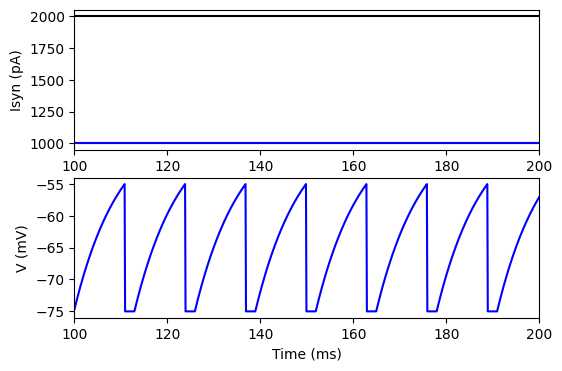

In [ ]:
def response_regularity(sigma=0):

  #generate the excitatory, inhibitory, and background currents
  Isyn_E = my_GWN(pars, sig=sigma)+1000.
  Isyn_I = my_GWN(pars, sig=sigma)+1000.
  I_bkg=300.

  #total current to the LIF neuron
  I_total = I_bkg + Isyn_E - Isyn_I

  #simulate the LIF neuron
  v, rec_spikes = run_LIF(pars, I =I_total)

  #calculate the CV for ISIs

  isi=np.diff(rec_spikes)
  cv_isi = np.std(isi)/np.mean(isi)
  print('cv_isi=',cv_isi)

  #plot the results
  plt.subplot(2,1,1)
  plt.plot(pars['range_t'], Isyn_E, 'r')
  plt.plot(pars['range_t'], Isyn_I, 'b')
  plt.plot(pars['range_t'], Isyn_E+Isyn_I, 'k')
  plt.xlabel('Time (ms)')
  plt.ylabel('Isyn (pA)');
  plt.xlim(100,200)

  plt.subplot(2,1,2)
  plt.plot(pars['range_t'], v, 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)');
  plt.xlim(100,200)

_ = widgets.interact(response_regularity, sigma = (0, 20, 1.))

In [ ]:
def my_OU(pars, sig, myseed=False):
    '''
    Expects:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean

    Returns:
    I          : Ornstein-Uhlenbeck input current
    '''

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tau_ou = pars['tau_ou'] # [ms]

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Initialize
    noise =  np.random.randn(Lt)
    I = np.zeros(Lt)
    I[0] = noise[0] * sig

    #generate OU
    for it in range(Lt-1):
        I[it+1] = I[it] + dt/tau_ou*(0.-I[it]) + np.sqrt(2.*dt/tau_ou) * sig * noise[it+1]

    return I

Execute the cell below to generate the GWN current and plot it out.

### Ornstein-Uhlenbeck (OU) current

We next study if the input current is temporally correlated and is modeled as an Ornstein-Uhlenbeck process $\eta(t)$, i.e., low-pass filtered GWN with a time constant $\tau_{\eta}$:

$$\tau_\eta \frac{d}{dt}\eta(t) = -\eta + \sigma_\eta\sqrt{2\tau_\eta}\xi(t).$$

Hint: An OU process as defined above has

$$E[\eta(t)]=0$$

and autocovariance

$$[\eta(t)\eta(t+\tau)]=\sigma_\eta^2e^{-|t-\tau|/\tau_\eta},$$

which can be used to check your code.

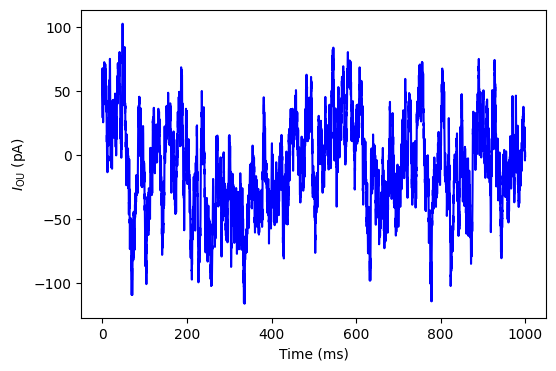

In [ ]:
pars = default_pars(T = 1000.)
pars['tau_ou'] = 10. #[ms]
sig_ou = 40.
I_ou = my_OU(pars, sig=sig_ou, myseed=1998)
plt.plot(pars['range_t'], I_ou, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$ (pA)');

Execute the cell below to inject the OU current to the LIF neuron and see its voltage response.

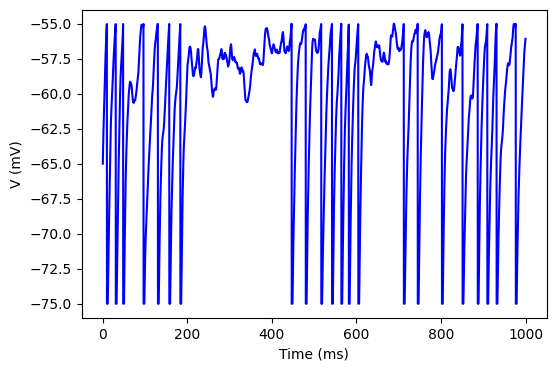

In [ ]:
v, rec_spikes = run_LIF(pars, I =I_ou+210.)
plt.plot(pars['range_t'], v, 'b')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)');

## Simulate synaptic conductance dynamics

Even GWN is a quite unphysiological to neurons. In vivo neuron receive spiking input which can be either excitatory (that drives the neuron towards the spike threshold) or inhibitory (that drives the neuron away from the spike threshold).

The spikes arriving at the neuron result in opening of channels that result in change in the neuron conductance and eventual flow of current whose direction is determined by the type of ion flowing.

This effect of an incoming spike at the neuron can be modelled a transient change in the neuron's conductance. The conductance change is convered to current  as:
\begin{align}
I_{\rm syn}(t) = -g_{\rm syn}(t)(V(t)-V_{\rm syn})  \\
\end{align}

The reversal potential $V_{\rm syn}$ describes the direction of current flow and the excitatory or inhibitory nature of the synapse.

In a neuronal network, the total synaptic input current $I$ is a sum of both excitatory and inhibitory inputs. Assuming the total excitatory (inhibitory) conductance received at time $t$ is $g_E(t)$ ($g_I(t)$), and its corresponding reversal potential is $V_E$ ($V_I$). Then the total synaptic current can be described as:

\begin{align}
I_{\rm syn}(V(t),t) = -g_E(t) (V-V_E) - g_I(t) (V-V_I). \\
\end{align}

Accordingly, the membrane potential dynamics of the LIF neuron under synaptic current drive becomes

\begin{align}
\tau_m\frac{dV(t)}{dt} = -(V(t)-V_L) - \frac{g_E(t)}{g_L} (V(t)-V_E) - \frac{g_I(t)}{g_L} (V(t)-V_I) + \frac{I_{\rm inj}}{g_L}.\quad (3)
\end{align}

We will use Eqn. (3) to simulate the conductance-based LIF neuron model below.

### Gating variable dynamics

The dynamics of $g_E$ and $g_I$ is determined by the gating variables of the synaptic channels. Each synaptic receptor channel has two states: either open or closed. When an input arrives, we denote $s$ as the fraction of open channels, and denote $T$ as the concentration of neurotransmitters. By denoting $\alpha_s$ and $\beta_s$ as the rate of transition between the two states, we have the change of $s$ described as

$$
\frac{ds}{dt} = \alpha_s T(1-s) - \beta_s s.
$$

If we model $T$ by a sequence of short pulses $\delta(t)$ at the input arrival times $t_k$, we can show that the gating variable dynamics are given by the following first order kinetics

$$
\frac{ds}{dt} = \alpha_s \sum_k\delta(t-t_k)(1-s) -s/\tau_s, \quad (4)
$$
where $\tau_s=1/\beta_s$ is defined as the synaptic time constant.


Staring at Eqn. (4) above, we expect that, under high density of pulses (high input rate), the gating variable $s$ will increase towards its bound, which we set to be 1 here. And because of the factor $(1-s)$, each input pulse will become less and less efficient in driving $s$. This phenomenon is known as synaptic saturation.

In fact, each open channel needs to take $\sim \tau_{s}$ to go back to the closed state. For fast AMPA (E) and GABA (I) dynamics with small $\tau_{s}$, it is often reasonable to assume that $s\ll 1$ such that one can ontain the following approximation

$$
\frac{ds}{dt} = \alpha_s \sum_k \delta(t-t_k) -s/\tau_s. \quad (5)
$$

Eqn. (5) can be analytically solved, and the solution takes the form of a linear summation of exponential functions.


### Synaptic conductance dynamics

The synaptic condutance is often modeled as $g=\bar{g}s$, where $\bar{g}$ is the maximum condutance if all synaptic channels are open. Accordingly, from Eqn. (5), we can describe the dynamics of excitatory and inhibitory condutances as

\begin{eqnarray}
\frac{dg_E(t)}{dt} &=& \bar{g}_E \sum_k \delta(t-t_k) -g_E(t)/\tau_E, \\
\frac{dg_I(t)}{dt} &=& \bar{g}_I \sum_k \delta(t-t_k) -g_I(t)/\tau_I.
\end{eqnarray}

In the absence of any presynaptic pulse inputs, the excitatory and inhibitory synaptic conductances will decay to zero with time constant $\tau_E$ and $\tau_I$ respectively. Each presynaptic pulse input will increase the conductance $g_{\rm X} (t)$ by an amount $\bar{g}_{X}$ for ${\rm X} =E, I$. Therefore, using the forward Euler scheme, we can derive the updating rule for the excitatory and inhibitory condutances

\begin{eqnarray}
\Delta g_X^n &=& -\frac{g_X^n}{\tau_X}\Delta t + \bar{g}_{X}\cdot N_{X}^{n} \\
g_X^{n+1} &=& g_X^n + \Delta g_X^n \quad {\rm for\ X}=E,\ I \\
\end{eqnarray}

where $N_{X}^{n}$ is the total number of the input pluses from presynaptic neurons within the time window $[n\Delta t, (n+1)\Delta t)$.

### Poisson input generator

The sequence of presynaptic pulse inputs can be approximately modeled as a Poisson process. The generation of the Poisson process can be realized by at least the following two ways:

- By definition, for a Poisson process with rate $\lambda$, the probability of finding one event in the time window with a sufficiently small length $\Delta t$ is $P(N = 1) = \lambda \Delta t$. Therefore, in each time window, we generate a uniformly distributed random variable $r \in [0,1]$ and generate a Poisson event when $r <\lambda \Delta t$.

- The interval $t_{k+1}-t_{k}$ between two Poisson events with rate $\lambda$ follows the exponential distribution, i.e., $P(t_{k+1}-t_{k}<t) = 1 - e^{\lambda t}$. Therefore, we only need to generate a set of exponentially distributed variables $\{s_k\}$ to obtain the timing of Poisson events $t_{k+1}=t_{k}+s_{k}$.

Below we use the first method and check the statistical property of the time interval between two Poisson events.

In [ ]:
def Poisson_generator(pars, rate, n, myseed=False):

    '''
    Generates poisson trains
    Expects:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

    Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
    '''

    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand<rate*dt/1000.)

    return poisson_train

Execute the cell below to generate a hundred Poisson trains.

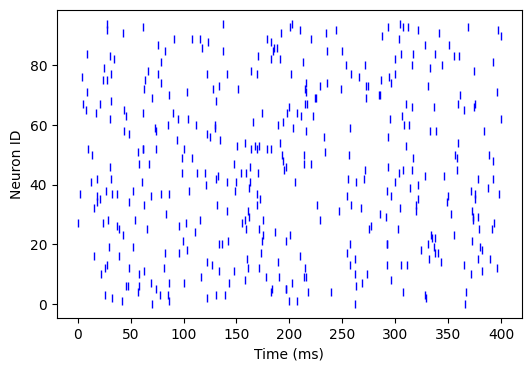

In [ ]:
pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100)
spT = pre_spike_train[pre_spike_train.sum(axis=1)>1.,:]

for i in range(spT.shape[0]):
    t_sp = pars['range_t'][spT[i, :]>0.5] #spike times
    plt.plot(t_sp, i*np.ones(len(t_sp)), 'b|')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID');

Execute the cell below and check that the interval time between two consecutive Poisson events follows the exponential distribution.

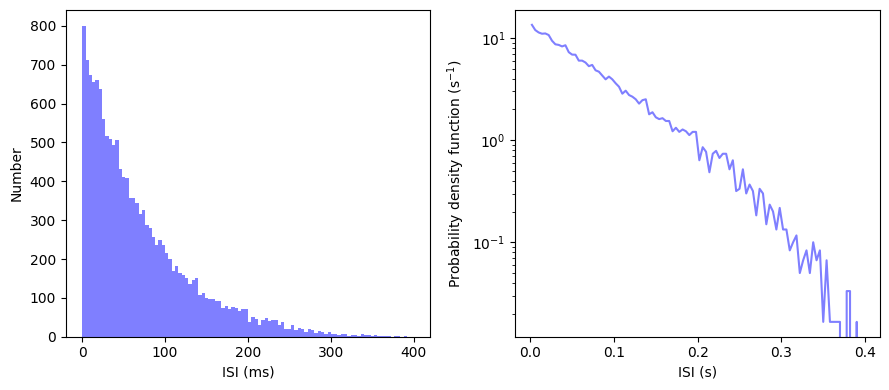

In [ ]:
pars = default_pars()
pars['T'] = 1000.
pre_spike_train = Poisson_generator(pars, rate=10, n=5000)
spT = pre_spike_train[pre_spike_train.sum(axis=1)>1.,:]
id_o = np.arange(pars['range_t'].size)
t_isi_temp = id_o[spT[0, :]>0.5]
t_isi = np.diff(t_isi_temp)*pars['dt']
for i in range(spT.shape[0]-1):
    t_isi_temp = id_o[spT[i+1, :]>0.5]
    t_isi = np.concatenate((t_isi, np.diff(t_isi_temp)*pars['dt']))

plt.figure(figsize=(9., 4.))

plt.subplot(1,2,1)
isi_count, isi_bin = np.histogram(t_isi, bins = np.arange(0, 400.1, 4.))
isi_bin = 0.5 * (isi_bin[1:] + isi_bin[:-1])
plt.bar(isi_bin, isi_count, width=4.0, color='b', alpha=0.5)
#plt.legend(loc='upper right')
plt.xlabel('ISI (ms)')
plt.ylabel('Number')

plt.subplot(1,2,2)
isi_count_normalize = isi_count/isi_count.sum()/(isi_bin[1]-isi_bin[0]) * 1000. #note the units
plt.semilogy(isi_bin/1000., isi_count_normalize, 'b', alpha=0.5)
plt.xlabel('ISI (s)')
plt.ylabel(r'Probability density function (s$^{-1}$)')
plt.tight_layout()

### Simulate LIF neuron with conductance-based synapses

We are now ready to simulate a LIF neuron with conductance based synaptic inputs! The following code defines the LIF neuron with synaptic input modelled as conductance transients.

In [ ]:
def run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
    '''
    conductance-based LIF dynamics

    Expects:
    pars               : parameter dictionary
    I_inj              : injected current [pA]. The injected current here can be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron

    Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
    gE         : postsynaptic excitatory conductance
    gI         : postsynaptic inhibitory conductance
    '''

    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
    VE, VI = pars['VE'], pars['VI']
    tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
    tref = pars['tref']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    gE = np.zeros(Lt)
    gI = np.zeros(Lt)
    I = I_inj * np.ones(Lt) #ensure I has length Lt

    if pre_spike_train_ex.max() == 0:
      pre_spike_train_ex_total = np.zeros(Lt)
    else:
      pre_spike_train_ex_total = pre_spike_train_ex.sum(axis=0) * np.ones(Lt)

    if pre_spike_train_in.max() == 0:
      pre_spike_train_in_total = np.zeros(Lt)
    else:
      pre_spike_train_in_total = pre_spike_train_in.sum(axis=0) * np.ones(Lt)

    # simulation
    rec_spikes = [] # recording spike times
    for it in range(Lt-1):
      if tr >0:
            v[it] = V_reset
            tr = tr-1
      elif v[it] >= V_th:         #reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            tr = tref/dt
      #update the synaptic conductance
      gE[it+1] = gE[it] - (dt/tau_syn_E)*gE[it] + gE_bar*pre_spike_train_ex_total[it+1]
      gI[it+1] = gI[it] - (dt/tau_syn_I)*gI[it] + gI_bar*pre_spike_train_in_total[it+1]

      #calculate the increment of the membrane potential
      dv = (-(v[it]-V_L) - (gE[it+1]/g_L)*(v[it]-VE) - \
              (gI[it+1]/g_L)*(v[it]-VI) + I[it]/g_L) * (dt/tau_m)

      #update membrane potential
      v[it+1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, gI

Execute the cell below to inject Poisson inputs to the conductance-based LIF neuron and see its conductance and voltage response.

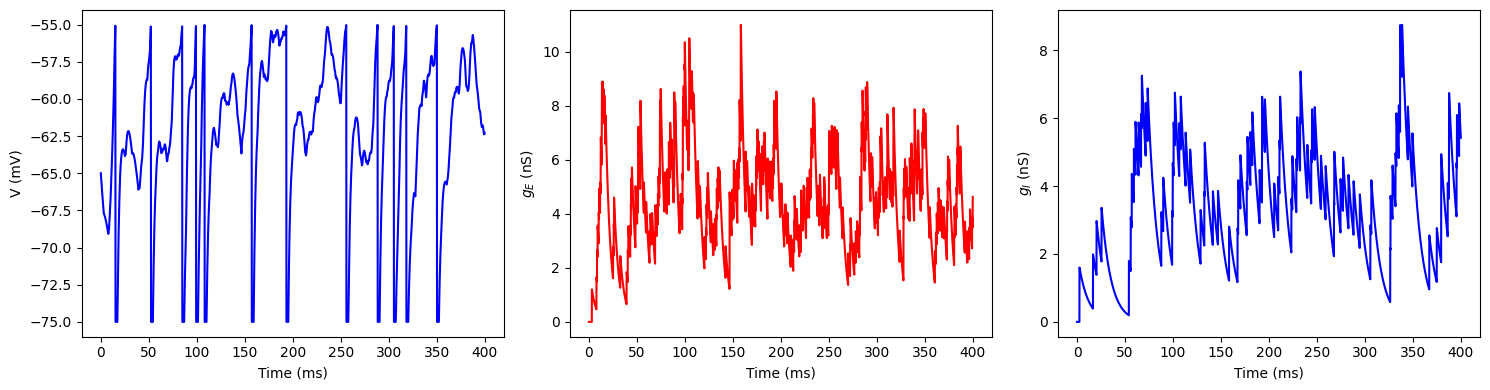

In [ ]:
pars = default_pars()
pars['gE_bar']    = 1.2 #[nS]
pars['VE']        = 0. #[mV]
pars['tau_syn_E'] = 5. #[ms]
pars['gI_bar']    = 1.6 #[nS]
pars['VI']        = -80. #[ms]
pars['tau_syn_I'] = 10. #[ms]

pre_spike_train_ex = Poisson_generator(pars, rate=10, n=80)
pre_spike_train_in = Poisson_generator(pars, rate=10, n=20) # 4:1

v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

plt.figure(figsize=(15., 4))
plt.subplot(1,3,1)
plt.plot(pars['range_t'], v, 'b')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)');

plt.subplot(1,3,2)
plt.plot(pars['range_t'], gE, 'r')
plt.xlabel('Time (ms)')
plt.ylabel(r'$g_E$ (nS)')

plt.subplot(1,3,3)
plt.plot(pars['range_t'], gI, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$g_I$ (nS)')

plt.tight_layout()



###Excitation and inhibition balance
In vivo a neuron in the neocortex receives a number of excitatory and inhibitory inputs. At the simplest we can assume that these input spikes follow Poissonian statistics.
In the following we will study how varying the ratio of excitatory and inhibitory inputs changes the firing rate and the spike time regularity.

To change the exc. and inh. inputs we will vary the firing rates. But if you wish you can vary the strength and/or number of these connections.

interactive(children=(FloatSlider(value=15.0, description='exc_rate', max=20.0, min=5.0, step=2.0), FloatSlide…

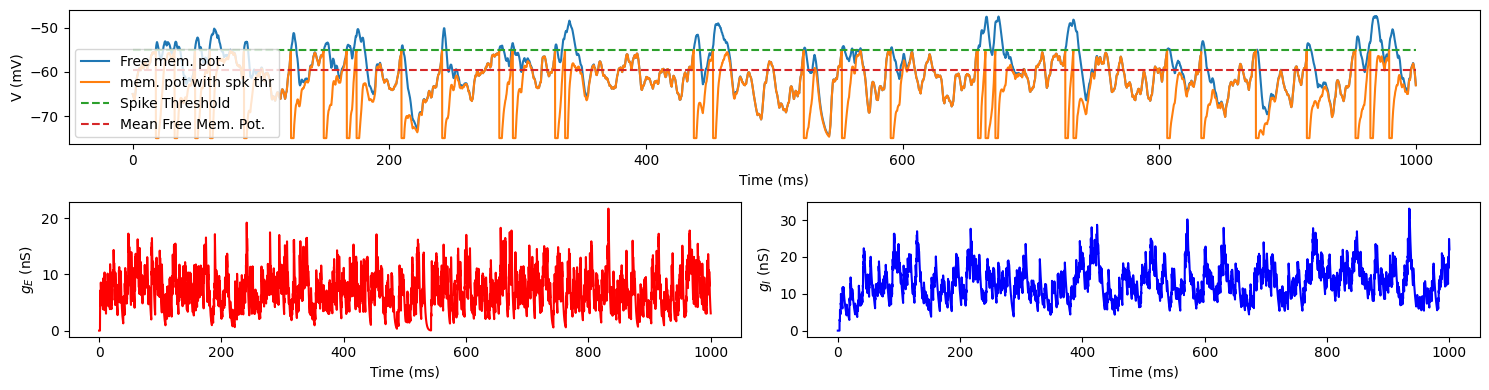

In [ ]:
def ei_balance_isi_regularity(exc_rate = 15, inh_rate = 45):
  pars = default_pars()
  # Set the duration of simulartion
  pars['T'] = 1000.
  pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]

  # Set the firing rate of the excitatory and inhibitory inputs
  exc_rate = 15. # excitatory firing rate
  inh_rate = 45. # inhibitory firing rate

  gE        = 3.   #nS
  E_rev     = 0.    #mv
  tau_syn_e = 2.    #ms
  gI        = 3.   #nS
  tau_syn_i = 5.   #ms
  I_rev     = -80.  #mv
  V_th      = -55.  #mV

  pars['gE_bar']    = gE
  pars['VE']        = E_rev
  pars['tau_syn_E'] = tau_syn_e
  pars['gI_bar']    = gI
  pars['VI']        = I_rev
  pars['tau_syn_I'] = tau_syn_i

  pre_spike_train_ex = Poisson_generator(pars, rate=exc_rate, n=80)
  pre_spike_train_in = Poisson_generator(pars, rate=inh_rate, n=20) # 4:1


  # Lets first simulate a neuron with identical input but with no spike threshold
  # so that we can look at the free membrane potential
  pars['V_th'] = 1e3
  v_fmp, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

  # Now simulate a LIP with a spike threshold
  pars['V_th'] = -55.
  v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)

  spike_rate = 1e3*len(rec_spikes)/pars['T']

  cv_isi = 0.
  if len(rec_spikes)>3:
    isi = np.diff(rec_spikes)
    cv_isi = np.std(isi)/np.mean(isi)

  print('Spike Rate = ', str(spike_rate))
  print('CV ISI = ', str(cv_isi))
  print('Mean of Free Mem Pot = ', str(np.mean(v_fmp)))
  print('STD of Free Mem Pot = ', str(np.std(v_fmp)))


  plt.figure(figsize=(15., 4))
  plt.subplot(2,1,1)
  plt.plot(pars['range_t'], v_fmp, label = 'Free mem. pot.')
  plt.plot(pars['range_t'], v, label = 'mem. pot with spk thr')
  plt.plot([pars['range_t'][0], pars['range_t'][-1]],[pars['V_th'], pars['V_th'] ],'--',label = 'Spike Threshold')
  plt.plot([pars['range_t'][0], pars['range_t'][-1]],[np.mean(v_fmp), np.mean(v_fmp) ],'--',label = 'Mean Free Mem. Pot.')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)');
  plt.legend()

  plt.subplot(2,2,3)
  plt.plot(pars['range_t'], gE, 'r')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_E$ (nS)')

  plt.subplot(2,2,4)
  plt.plot(pars['range_t'], gI, 'b')
  plt.xlabel('Time (ms)')
  plt.ylabel(r'$g_I$ (nS)')

  plt.tight_layout()
  return rec_spikes

rec_spikes = widgets.interact(ei_balance_isi_regularity, inh_rate = (10., 60., 5.), exc_rate = (5.,20.,2))

###Task: Take the spike output and test how Poissonian it is.
To this end plot the histogram of the ISI intervals and check for the independence of adjacent spike time. The code above return the variable rec_spikes.

###Task: Plot the various outputs
Now systematically vary the exc. and inh. rate. Measure the mean free membrane potential, spike rate and CV of the output spike pattern.
Depending on the range and resolution it may take some time so start with a coarser resolution.

In [ ]:
# Set the range of Excitatory and inhibtory firing rates
exc_rate = np.arange(5.,30.,2) # excitatory firing rate [SET YOUR RANGE HERE]
inh_rate = np.arange(5.,80.,5) # inhibitory firing rate [SET YOUR RANGE HERE]

# Set the duration of simulartion
pars['T'] = 1000.
pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
V_th = -55.

mean_fmp = np.zeros((len(exc_rate),len(inh_rate)))
std_fmp = np.zeros((len(exc_rate),len(inh_rate)))
spk_rate = np.zeros((len(exc_rate),len(inh_rate)))
cv_isi = np.empty((len(exc_rate),len(inh_rate)))
cv_isi[:] = np.NaN

for ii in range(len(exc_rate)):
  for jj in range(len(inh_rate)):
    pre_spike_train_ex = Poisson_generator(pars, rate=exc_rate[ii], n=80)
    pre_spike_train_in = Poisson_generator(pars, rate=inh_rate[jj], n=20) # 4:1
    pars['V_th'] = 1e4
    v_fmp, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)
    pars['V_th'] = V_th
    v, rec_spikes, gE, gI = run_LIF_cond(pars, 0, pre_spike_train_ex, pre_spike_train_in)
    mean_fmp[ii,jj] = np.mean(v_fmp)
    std_fmp[ii,jj] = np.std(v_fmp)
    spk_rate[ii,jj] = 1e3*len(rec_spikes)/pars['T']
    if len(rec_spikes)>3:
      isi = np.diff(rec_spikes)
      cv_isi[ii,jj] = np.std(isi)/np.mean(isi)

<ipython-input-23-051f980d9546>:31: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
<ipython-input-23-051f980d9546>:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.clim(0,1)


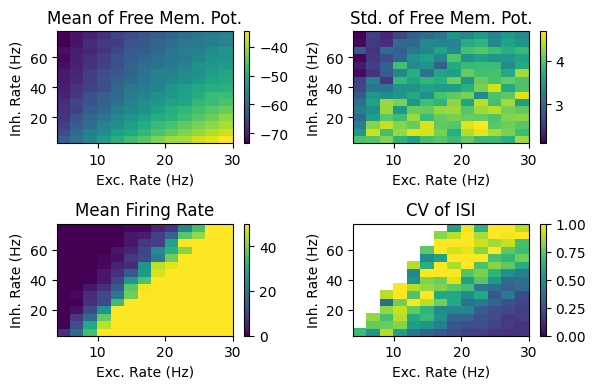

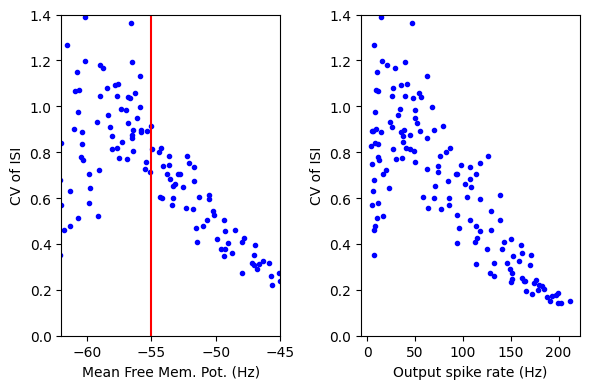

In [ ]:
plt.figure()

plt.subplot(2,2,1)
plt.pcolor(exc_rate,inh_rate,mean_fmp.T)
plt.colorbar()
#plt.clim([-70,-55])
plt.xlabel('Exc. Rate (Hz)')
plt.ylabel('Inh. Rate (Hz)')
plt.title('Mean of Free Mem. Pot.')

plt.subplot(2,2,2)
plt.pcolor(exc_rate,inh_rate,std_fmp.T)
plt.colorbar()
plt.xlabel('Exc. Rate (Hz)')
plt.ylabel('Inh. Rate (Hz)')
plt.title('Std. of Free Mem. Pot.')


# Plot Firing rate as a function of both mean and std. Firing rate is rendered as color
plt.subplot(2,2,3)
plt.pcolor(exc_rate,inh_rate,spk_rate.T)
plt.colorbar()
plt.clim(0,50)
plt.xlabel('Exc. Rate (Hz)')
plt.ylabel('Inh. Rate (Hz)')
plt.title('Mean Firing Rate')

# Plot Spike time irregularity (CV_ISI) as a function of both mean and std. CV_isi is rendered as color
plt.subplot(2,2,4)
plt.pcolor(exc_rate,inh_rate,cv_isi.T)
plt.colorbar()
plt.clim(0,1)
plt.xlabel('Exc. Rate (Hz)')
plt.ylabel('Inh. Rate (Hz)')
plt.title('CV of ISI')

plt.tight_layout()

plt.figure()
plt.subplot(1,2,1)
plt.plot(mean_fmp,cv_isi,'.b')
plt.plot([V_th, V_th],[0 ,1.4],'r')
plt.ylim((0,1.4))
plt.xlim((-62,-45))
plt.xlabel('Mean Free Mem. Pot. (Hz)')
plt.ylabel('CV of ISI')

plt.subplot(1,2,2)
plt.plot(spk_rate,cv_isi,'.b')
plt.ylim((0,1.4))
plt.xlabel('Output spike rate (Hz)')
plt.ylabel('CV of ISI')

plt.tight_layout()


Study the plots above and make an inference about how excitation and inhibition balance affects the output spike patterns.